## Data 620 - Week 3 Assignment

Baron Curtin, Heather Geiger

In [10]:
# load libraries
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [11]:
# load and parse facebook data
fb_path = Path('./facebook')
edges_files = {str(f.stem): f for f in fb_path.rglob('*edges')}
circles_files = {str(f.stem): f for f in fb_path.rglob('*circles')}

In [12]:
# create empty graph
g = nx.Graph()

In [13]:
# create function to parse information from files (DRY)
def parse_file_info(my_file, node, file_type=''):
    # ensure type is passed so function can appropriately process
    if (file_type == '') | (node == ''):
        raise ValueError('Please fill in a valid file type')
    
    # use file type argument to correctly process information    
    with open(my_file, 'r') as f:
        content = f.read()
        lines = content.split('\n')
        
        # proper parsing based on file type
        if file_type == 'edges':
            without_main_node = [tuple(int(d) for d in l.split(' ')) 
                                 for l in lines
                                 if l != '']
            with_main_node = [tuple((int(node), int(x))) 
                              for l in lines
                              for x in l.split(' ')
                              if l != '']
            info = [*with_main_node, *without_main_node]
        elif file_type == 'circles':
            info = [(int(node), int(n))
                    for l in lines
                    for n in l.split('\t')[1:]
                    if l != '']
        return info
    
edges = {node: parse_file_info(edge_file, node, 'edges') 
         for node, edge_file in edges_files.items()}
circles = {node: parse_file_info(circle_file, node, 'circles') 
         for node, circle_file in circles_files.items()}

## Graph Creation

In [14]:
# begin adding nodes/edges to graph

# use node 0
g.add_edges_from(edges['0'])
g.add_edges_from(circles['0'])

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


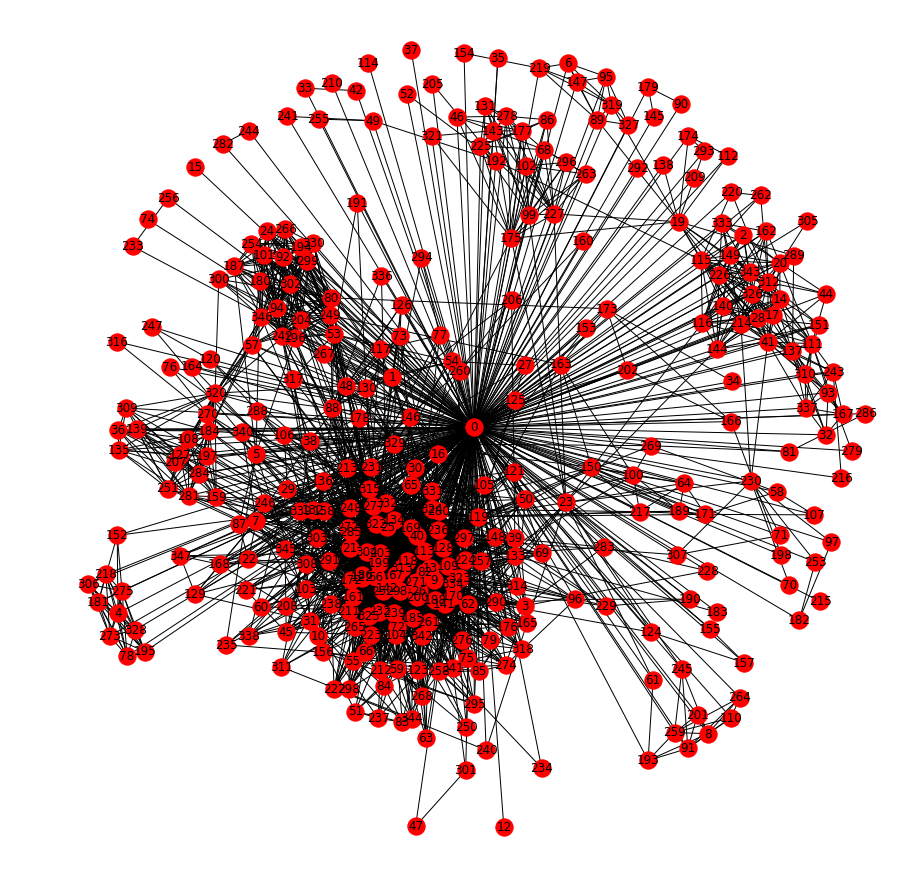

In [15]:
# make plot area larger and draw graph
plt.figure(3,figsize=(12,12)) 
nx.draw(g, with_labels=True)
plt.show()

In [16]:
g.number_of_nodes()

343